# Notebook 02: Data Preprocessing, EDA & Feature Engineering

This notebook covers:
- Data cleaning (nulls, duplicates, basic integrity checks)
- Feature engineering (time features, genre multi-hot encoding)
- Feature selection (frequency filtering)
- Dimensionality reduction (PCA for visualization)
- Preparation of train/validation/test splits for recommender modeling

Maps to Capstone Step 3: Data Preprocessing, Applied EDA & Feature Engineering.

In [12]:
from google.colab import files
uploaded = files.upload()

Saving movies.dat to movies (1).dat
Saving ratings.dat to ratings (1).dat
Saving users.dat to users (1).dat


In [13]:
import pandas as pd

movies = pd.read_csv("movies.dat", sep="::", engine="python",
                     names=["movie_id", "title", "genres"], encoding="latin-1")
ratings = pd.read_csv("ratings.dat", sep="::", engine="python",
                      names=["user_id", "movie_id", "rating", "timestamp"])
users = pd.read_csv("users.dat", sep="::", engine="python",
                    names=["user_id", "gender", "age", "occupation", "zip_code"])

print(movies.shape, ratings.shape, users.shape)

(3883, 3) (1000209, 4) (6040, 5)


In [14]:
def basic_checks(df, name):
    print(f"\n==== {name} ====")
    print("Missing values:\n", df.isna().sum())
    print("Duplicates:", df.duplicated().sum())

basic_checks(movies, "movies")
basic_checks(ratings, "ratings")
basic_checks(users, "users")

print("\nRating values:", sorted(ratings["rating"].unique()))
print("Min timestamp:", ratings["timestamp"].min(), "Max timestamp:", ratings["timestamp"].max())



==== movies ====
Missing values:
 movie_id    0
title       0
genres      0
dtype: int64
Duplicates: 0

==== ratings ====
Missing values:
 user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64
Duplicates: 0

==== users ====
Missing values:
 user_id       0
gender        0
age           0
occupation    0
zip_code      0
dtype: int64
Duplicates: 0

Rating values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Min timestamp: 956703932 Max timestamp: 1046454590


In [15]:
movies = movies.drop_duplicates()
ratings = ratings.drop_duplicates()
users = users.drop_duplicates()

print("After dedup:")
print(movies.shape, ratings.shape, users.shape)


After dedup:
(3883, 3) (1000209, 4) (6040, 5)


In [16]:
import pandas as pd

ratings["datetime"] = pd.to_datetime(ratings["timestamp"], unit="s")
ratings["year"] = ratings["datetime"].dt.year
ratings["month"] = ratings["datetime"].dt.month
ratings["dayofweek"] = ratings["datetime"].dt.dayofweek

ratings[["timestamp", "datetime", "year", "month", "dayofweek"]].head()


,timestamp,datetime,year,month,dayofweek
0,978300760,2000-12-31 22:12:40,2000,12,6
1,978302109,2000-12-31 22:35:09,2000,12,6
2,978301968,2000-12-31 22:32:48,2000,12,6
3,978300275,2000-12-31 22:04:35,2000,12,6
4,978824291,2001-01-06 23:38:11,2001,1,5


In [17]:
import re
import numpy as np

def extract_year(title):
    m = re.search(r"\((\d{4})\)", str(title))
    return int(m.group(1)) if m else np.nan

movies["release_year"] = movies["title"].apply(extract_year)
movies[["title", "release_year"]].head(10)


,title,release_year
0,Toy Story (1995),1995
1,Jumanji (1995),1995
2,Grumpier Old Men (1995),1995
3,Waiting to Exhale (1995),1995
4,Father of the Bride Part II (1995),1995
5,Heat (1995),1995
6,Sabrina (1995),1995
7,Tom and Huck (1995),1995
8,Sudden Death (1995),1995
9,GoldenEye (1995),1995


In [18]:
from sklearn.preprocessing import MultiLabelBinarizer

movies["genre_list"] = movies["genres"].str.split("|")
mlb = MultiLabelBinarizer()
genre_ohe = pd.DataFrame(mlb.fit_transform(movies["genre_list"]),
                         columns=[f"genre_{g}" for g in mlb.classes_],
                         index=movies.index)

movies_fe = pd.concat([movies[["movie_id", "release_year"]], genre_ohe], axis=1)
movies_fe.head()


,movie_id,release_year,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1995,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,1995,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
genre_counts = genre_ohe.sum().sort_values(ascending=False)
genre_counts.head(10), genre_counts.tail(10)


(genre_Drama         1603
 genre_Comedy        1200
 genre_Action         503
 genre_Thriller       492
 genre_Romance        471
 genre_Horror         343
 genre_Adventure      283
 genre_Sci-Fi         276
 genre_Children's     251
 genre_Crime          211
 dtype: int64,
 genre_Children's     251
 genre_Crime          211
 genre_War            143
 genre_Documentary    127
 genre_Musical        114
 genre_Mystery        106
 genre_Animation      105
 genre_Fantasy         68
 genre_Western         68
 genre_Film-Noir       44
 dtype: int64)

### Feature Selection (Filter Method)
We apply a simple filter-based feature selection by removing extremely rare genres.
This reduces noise and improves generalization.


In [20]:
min_movies_per_genre = 50
keep_genres = genre_counts[genre_counts >= min_movies_per_genre].index.tolist()

movies_fe_selected = pd.concat([movies[["movie_id", "release_year"]],
                                genre_ohe[keep_genres]], axis=1)

print("Selected genre features:", len(keep_genres))
movies_fe_selected.head()


Selected genre features: 17


,movie_id,release_year,genre_Drama,genre_Comedy,genre_Action,genre_Thriller,genre_Romance,genre_Horror,genre_Adventure,genre_Sci-Fi,genre_Children's,genre_Crime,genre_War,genre_Documentary,genre_Musical,genre_Mystery,genre_Animation,genre_Fantasy,genre_Western
0,1,1995,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,2,1995,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
2,3,1995,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1995,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1995,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


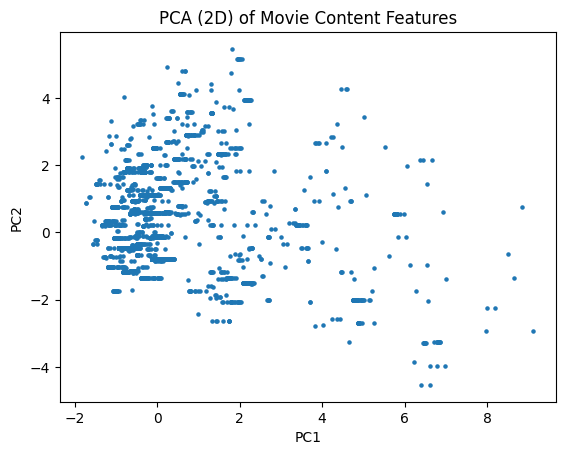

Explained variance ratio: [0.10899878 0.09737108]


In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = movies_fe_selected.drop(columns=["movie_id"]).fillna(0)
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], s=5)
plt.title("PCA (2D) of Movie Content Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)


In [22]:
ratings_sorted = ratings.sort_values("datetime")

# Split by time: 80% train, 10% val, 10% test
n = len(ratings_sorted)
train_end = int(0.8 * n)
val_end = int(0.9 * n)

train = ratings_sorted.iloc[:train_end]
val = ratings_sorted.iloc[train_end:val_end]
test = ratings_sorted.iloc[val_end:]

print("Train:", train.shape, "Val:", val.shape, "Test:", test.shape)
print("Train last date:", train["datetime"].max())
print("Val last date:", val["datetime"].max())
print("Test last date:", test["datetime"].max())


Train: (800167, 8) Val: (100021, 8) Test: (100021, 8)
Train last date: 2000-12-02 14:52:18
Val last date: 2000-12-29 23:42:47
Test last date: 2003-02-28 17:49:50


### Why Time-based Splitting?

To avoid data leakage, we split ratings chronologically. In real systems,
models are trained on historical interactions and evaluated on future ones.

This makes offline evaluation closer to real-world deployment behavior.
